In [460]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [493]:
"""
Referece: https://github.com/sbird/spb_common

Module for computing the 5 least squares regression methods detailed in
        Linear regression in astronomy.
        Isobe, Takashi; Feigelson, Eric D.; Akritas, Michael G.; Babu, Gutti Jogesh
        Astrophysical Journal, Part 1 (ISSN 0004-637X), vol. 364, Nov. 20, 1990, p. 104-113
        http://adsabs.harvard.edu/abs/1990ApJ...364..104I
These methods are appropriate when the intrinsic scatter in the data is much larger
than the error on each data point.
"""

import numpy as np
import scipy.stats as st

def leastsq(x,y, method=5):
    """
       Compute the least squares fit to y = beta x + alpha,
       using one of the 5 methods outlined in
       http://adsabs.harvard.edu/abs/1990ApJ...364..104I
       Method 1 minimises distance from Y given X (ie, the standard least squares fit)
       Method 2 minimises distance from X given Y
       Method 3 (recommended) is the OLS bisector, which gives a line bisecting the above two.
       Method 4 (Orthogonal regression) minimises perpendicular distance from the line to points
       Method 5 is the geometric mean of the slopes from methods 1 and 2.
       Method 6 is the Theil-Sen estimator: the median of the pairwise slopes.
       (See Akritas 95,  http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476499)
       Returns:
              (alpha, beta, bvar), the intercept slope and variance of the slope
    """
    #Define some sums
    xbar = np.mean(x)
    ybar = np.mean(y)
    xdif = x-xbar
    ydif = y-ybar
    sxx = np.sum(xdif**2)
    syy = np.sum(ydif**2)
    sxy = np.sum(ydif*xdif)

    #Check for zeros
    if sxx == 0 or syy == 0 or sxy == 0:
        raise ValueError("Least Squares ill-defined")
    if method > 6 or method < 1:
        raise ValueError("Method not recognised")

    #These formulas are taken from Table 1 of Isobe et al, page 3
    #Minimise distance from Y given X
    beta1 = sxy/sxx
    #Variance of b1
    bvar1 = np.sum(xdif**2*(ydif-beta1*xdif)**2)/sxx**2
    #Minimise distance from X given Y
    beta2 = syy/sxy
    #Variance of b2
    bvar2 = np.sum(ydif**2*(ydif-beta2*xdif)**2)/sxy**2
    #Covariance of b1 and b2
    covb12 = np.sum(xdif*ydif*(ydif-beta2*xdif)*(ydif-beta1*xdif))/(beta1*sxx**2)

    if method == 1:
        beta = beta1
        bvar = np.sqrt(bvar1) # FIXED VINICIUS
    if method == 2:
        beta = beta2
        bvar = np.sqrt(bvar2) # FIXED VINICIUS
    if method == 3:
        #OLS bisector: line that bisects the above two.
        beta1p1 = 1+beta1**2
        beta2p1 = 1+beta2**2
        beta = (beta1*beta2 - 1 + np.sqrt(beta1p1*beta2p1))/(beta1+beta2)
        #Variance
        prefac = beta**2 / ( (beta1 + beta2)**2 * beta1p1 * beta2p1)
        var = beta2p1**2 * bvar1 + 2 * beta1p1 * beta2p1 * covb12 + beta1p1**2 * bvar2
        bvar = np.sqrt(prefac*var) # FIXED VINICIUS

    if method == 4:
        #Orthogonal: minimise perpendicular distance from line to points
        beta = 0.5*((beta2-1./beta1)+np.sign(sxy)*np.sqrt(4+(beta2-1./beta1)**2))
        prefac = beta**2 / (4*beta1**2 + (beta1*beta2 - 1)**2)
        bvar = prefac * ( bvar1/beta1**2 + 2*covb12 + beta1**2*bvar2 )

    if method == 5:
        #Reduced major axis:
        beta = np.sign(sxy)*np.sqrt(beta1*beta2)
        bvar = 0.25 * (beta2/beta1 * bvar1 + 2*covb12 + beta1/beta2 * bvar2)

    if method == 6:
        #Theil-Sen estimator for uncensored data: the median of the slopes.
        yy = np.subtract.outer(y,y)
        xx = np.subtract.outer(x,x)
        ind = np.where(xx != 0)
        beta = np.median(yy[ind]/xx[ind])
        #Can't find a formula for the variance
        bvar = 0

    #The intercept
    alpha = ybar - beta*xbar

    return (alpha, beta, bvar)

def pearson(x,y,alpha, beta, method=3):
    """Find the Pearson correlation coefficient between the fit and the data.
        if method == 1 return the Pearson r of y and the fit to y
        if method == 2, the same but with x and y reverse
        if method == 3 the geometric mean of the above
    """
    #Vector of expected y from fit
    fity = beta*x + alpha
    #Vector of expected x from fit
    fitx = (y - alpha) / beta
    #Scatter from y axis: method 1 minimises this.
    (pry,_) = st.pearsonr(y,fity)
    if method == 1:
        return pry
    (prx,_) = st.pearsonr(x,fitx)
    if method == 2:
        return prx
    return np.sqrt(pry*prx)

def kstest(x,y,alpha, beta):
    """Find the K-S test probability that the fit and the data were from the same distribution"""
    #Vector of expected y from fit
    fity = beta*x + alpha
    #Vector of expected x from fit
    fitx = (y - alpha) / beta
    (D1, p1) = st.ks_2samp(y,fity)
    (D2, p2) = st.ks_2samp(x,fitx)
    return (np.sqrt(D1*D2),np.sqrt(p1*p2))

In [494]:
class OLS(object):
    """
    Class to estimate the ordinary least-squares regression coefficients for
    OLS(X|Y), OLS(Y|X) and OLS bisector as decribed in Isobe et al. (1990).
    
    TO DO: slope and intercept variances
    
    References:
    Isobe, T., Feigelson, E. D., Akritas, M. G., & Babu, G. J. 1990, ApJ, 364, 104
    """
    def __init__(self, X, y):
        """
        X : numpy array (n, 1)
        y : numpy array (n, ) 
        """ 
        
        N = X.shape[0]
        K = 2 # number of regression parameters (slope and intercept, OLS)
        x_mean = X[:,0].mean()
        x_res = X[:,0] - x_mean
        y_mean = y.mean()
        y_res = y - y_mean
        Sxx = sum(x_res**2)
        Syy = sum(y_res**2)
        Sxy = sum(x_res*y_res)

        # OLS(Y|X)
        reg_direct = LinearRegression().fit(X, y)
        self.a1 = reg_direct.intercept_
        self.b1 = reg_direct.coef_[0]
        self.R2 = reg_direct.score(X, y)
        self.rms1 = np.sqrt(sum((y-reg_direct.predict(X))**2)/(N-K)) # in units of Y
        self.var_b1 = np.sqrt((1/Sxx**2)*(sum((x_res**2)*(y-self.b1*X[:,0]-y_mean+self.b1*x_mean)**2)))

        self.var_a1 = (1/(N**2)) * sum(
                                        (
                                        y_res - \
                                        self.b1 * x_res - \
                                        N * x_mean * \
                                          (
                                            (1/Sxx) * \
                                            x_res * \
                                            (y_res - self.b1 * x_res)
                                          )
                                        )**2
                                      )

        # OLS(X|Y)
        XX = X.reshape(-1)
        yy = y.reshape(-1,1)
        reg_inverse = LinearRegression().fit(yy, XX)
        self.a2 = -reg_inverse.intercept_/reg_inverse.coef_[0]
        self.b2 = 1/reg_inverse.coef_[0]
        y_hat = self.a2 + self.b2*XX
        self.rms2 = np.sqrt(sum((yy[:,0]-y_hat)**2)/(N-K)) # in units of Y
        self.var_b2 = np.sqrt((1/Sxy**2)*(sum((y_res**2)*(y-self.b2*X[:,0]-y_mean+self.b2*x_mean)**2)))
    
        cov_b1_b2 = (1/(self.b1*Sxx**2))*\
                                            sum(x_res * \
                                                y_res * \
                                               (y_res - self.b1 * x_res) * \
                                               (y_res - self.b2 * x_res)
                                               )
        b1_1 = 1 + (self.b1**2)
        b2_1 = 1 + (self.b2**2)
        b1_b2 = (self.b1 + self.b2)**2
        
        # OLS bisector
        self.b3 = 1/(self.b1+self.b2) * (self.b1*self.b2 - 1 + np.sqrt((1+self.b1**2) * (1+self.b2**2)))
        self.a3 = y.mean() - self.b3*X.mean()
        y_hat = self.a3 + self.b3*X[:,0]
        self.rms3 = np.sqrt(sum((y-y_hat)**2)/(N-K)) # in units of Y 
        
        
        self.var_b3 = (
                        (self.b3**2) / (b1_b2 * b1_1 * b2_1)) * \
                       (
                        (b2_1**2) * self.var_b1 + \
                        2 * (b1_1 * b2_1 * cov_b1_b2) + \
                        (b1_1**2) * self.var_b2
                       )

In [495]:
df = pd.read_csv('../data/lsigma_new.csv')
df.head()

,name,lum,sig,oh,ewhb,ion,te,ne,chb,z,ref,type,class,sigobs,photobs,out
0,UM238,40.024,1.270,7.891,1.554,0.520,4.186,2.938,0.233,0.01427,1,Gaussian Profile,G,FEROS,B&C,0
1,mrk557,40.668,1.761,8.697,0.996,-0.715,4.146,2.573,0.383,0.01328,1,Irregular Profile,I,COUDÉ,B&C,0
2,UM304,41.546,1.893,0.000,0.000,0.000,4.146,2.309,0.000,0.01570,14,Profile with Components,C,COUDÉ,Others,0
3,cts1001,40.810,1.683,7.961,1.775,0.059,4.173,2.927,0.189,0.02263,1,Irregular Profile,I,FEROS,B&C,0
4,UM306,40.245,1.282,8.184,1.375,0.344,4.065,1.423,0.082,0.01649,1,Gaussian Profile,G,FEROS,B&C,0


In [496]:
df81 = df[(df['sigobs']=="FEROS") & (df['photobs'] != "Others")]
df81.shape

(81, 16)

In [497]:
X = df81['sig'].to_numpy().reshape(-1,1)
y = df81['lum'].to_numpy()

res = OLS(X,y)
print(res.R2.round(3))
print(res.a1.round(2), res.var_a1.round(2), res.b1.round(2), res.var_b1.round(2), res.rms1.round(2))
print(res.a2.round(2), res.b2.round(2), res.var_b2.round(2), res.rms2.round(2))
print(res.a3.round(2), res.b3.round(2), res.var_b3.round(2), res.rms3.round(2))

0.721
36.21 0.1 3.01 0.23 0.37
34.52 4.18 0.27 0.44
35.49 3.51 0.16 0.39


Same results as that in **Table 6** in Bordalo & Telles (2011). 

In [498]:
print(leastsq(X[:,0],y, method=1))
print(leastsq(X[:,0],y, method=2))
print(leastsq(X[:,0],y, method=3))

(36.21033353603593, 3.0128123072699364, 0.22884263536268065)
(34.51557346760109, 4.179923049858123, 0.2686075298532924)
(35.490354912743285, 3.508631627850659, 0.23010153271682218)


Using ```OLS``` from ```statsmodels```:

In [457]:
X = sm.add_constant(X)
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     203.9
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           1.37e-23
Time:                        17:32:59   Log-Likelihood:                -34.325
No. Observations:                  81   AIC:                             72.65
Df Residuals:                      79   BIC:                             77.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.2103      0.309    117.123      0.0

In [145]:
# With linear algebra 
# numpy arrays

In [146]:
N = X.shape[0]
p = X.shape[1] + 1  # plus one because LinearRegression adds an intercept term

X_with_intercept = np.empty(shape=(N, p), dtype=float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = X

In [147]:
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
print(beta_hat)

[36.21033354  3.01281231]


In [148]:
y_hat = beta_hat[0] + beta_hat[1]*X
residuals = y - y_hat
residual_sum_of_squares = residuals.T @ residuals

In [152]:
sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

SE(beta_hat[0]): 0.6834221065095071
SE(beta_hat[1]): 0.4663663883215362


??

In [124]:
X = pd.DataFrame(np.random.randn(1000,3), columns=['X1','X2','X3'])
y = pd.DataFrame(np.random.randn(1000,1), columns=['Y'])        

model = LinearRegression()
model.fit(X=X, y=y)

LinearRegression()

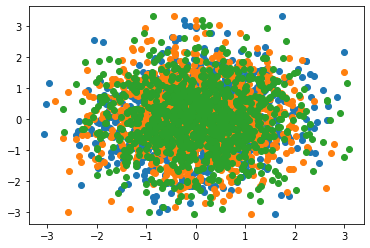

In [125]:
for i in range(X.shape[1]):
    plt.scatter(X.iloc[:,i],y)
plt.show()

In [102]:
N = len(X)
p = len(X.columns) + 1  # plus one because LinearRegression adds an intercept term

In [103]:
X_with_intercept = np.empty(shape=(N, p), dtype=float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = X.values

In [104]:
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
print(beta_hat)

[[ 0.14535439]
 [-0.04273738]
 [ 0.13531178]
 [-0.20566317]]


In [105]:
y_hat = model.predict(X)
residuals = y.values - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

SE(beta_hat[0]): 0.6629828493155504
SE(beta_hat[1]): 0.5190906163373692
SE(beta_hat[2]): 0.5941937629410118
SE(beta_hat[3]): 0.5361927749903787
